# Table of Contents
 <p><div class="lev1"><a href="#Imports"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></div><div class="lev1"><a href="#Load-data-with-annotations"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data with annotations</a></div><div class="lev2"><a href="#Load-cef-file"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load cef file</a></div><div class="lev2"><a href="#Load-genes-from-Panther-GO-annotation"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load genes from Panther GO annotation</a></div><div class="lev1"><a href="#Calculate-correlation"><span class="toc-item-num">3&nbsp;&nbsp;</span>Calculate correlation</a></div><div class="lev2"><a href="#Prepare-the-dataset"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Prepare the dataset</a></div><div class="lev2"><a href="#Calculate-correlation-and-filter-core-genes"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Calculate correlation and filter core genes</a></div><div class="lev1"><a href="#Others"><span class="toc-item-num">4&nbsp;&nbsp;</span>Others</a></div><div class="lev2"><a href="#Visualy-check-the-score-separation"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Visualy check the score separation</a></div><div class="lev2"><a href="#CrossValidation"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>CrossValidation</a></div>

# Imports

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import division
from itertools import izip
import pandas as pd
from backSPIN import backSPIN, fit_CV
from Cef_tools import *
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from seaborn import violinplot

# Load data with annotations

## Load cef file

In [3]:
df, rows_annot, cols_annot, headers  = cef2df('Human_Embryo_fulldataset.cef')

In [5]:
cef = CEF_obj()
cef.readCEF('Human_Embryo_fulldataset.cef')
df = pd.DataFrame(data = cef.matrix, columns=cef.col_attr_values[0], index=cef.row_attr_values[0])

In [10]:
pd.DataFrame(data = cef.col_attr_values,index=cef.col_attr_names,columns=df.columns, dtype=object)

,1772067_089_A01,1772067_089_A02,1772067_089_A03,1772067_089_A04,1772067_089_A05,1772067_089_A06,1772067_089_A08,1772067_089_A09,1772067_089_A11,1772067_089_B01,...,1772122_224_H01,1772122_224_H02,1772122_224_H04,1772122_224_H05,1772122_224_H06,1772122_224_H07,1772122_224_H08,1772122_224_H09,1772122_224_H10,1772122_224_H12
Cell_ID,1772067_089_A01,1772067_089_A02,1772067_089_A03,1772067_089_A04,1772067_089_A05,1772067_089_A06,1772067_089_A08,1772067_089_A09,1772067_089_A11,1772067_089_B01,...,1772122_224_H01,1772122_224_H02,1772122_224_H04,1772122_224_H05,1772122_224_H06,1772122_224_H07,1772122_224_H08,1772122_224_H09,1772122_224_H10,1772122_224_H12
Cell_type,hMgl,hRgl2a,Unk,hNProg,hProgBP,hProgM,hNProg,hOMTN,hRgl2a,Unk,...,Unk,hNProg,hProgBP,Unk,Unk,hOMTN,hProgBP,hMgl,hNProg,hNProg
Timepoint,week_7,week_7,week_7,week_7,week_7,week_7,week_7,week_7,week_7,week_7,...,week_8,week_8,week_8,week_8,week_8,week_8,week_8,week_8,week_8,week_8


In [12]:
pd.DataFrame(data = cef.row_attr_values,index=cef.row_attr_names, columns=df.index, dtype=object)

,DDX11L1,WASH7P_p1,LINC01002_loc4,LOC100133331_loc1,LOC100132287_loc2,LOC101928626,MIR6723,LOC100133331_loc2,LOC100288069_p1,LINC00115,...,NLGN4Y,TTTY14,CD24,TXLNGY_p1,KDM5D,EIF1AY,RPS4Y2,SPRY3_loc2,VAMP7_loc1,DDX11L16_loc1
Gene,DDX11L1,WASH7P_p1,LINC01002_loc4,LOC100133331_loc1,LOC100132287_loc2,LOC101928626,MIR6723,LOC100133331_loc2,LOC100288069_p1,LINC00115,...,NLGN4Y,TTTY14,CD24,TXLNGY_p1,KDM5D,EIF1AY,RPS4Y2,SPRY3_loc2,VAMP7_loc1,DDX11L16_loc1


In [104]:
df.shape

(19388, 1695)

## Load genes from Panther GO annotation

In [105]:
cell_cycle_putative = open('PANTHER_cell_cycle_genes.txt').read().split('\n')

# Calculate correlation

## Prepare the dataset

In [108]:
#Limit the dataset to the putative cell_cycle genes
cell_cycle_putative = [i for i in cell_cycle_putative if i in df.index]
df = df.ix[cell_cycle_putative, :]

# Filter away lowly expressed
df = df.ix[df.sum(1)>8, :]
df = df.ix[(df>1).sum(1)>5, :]
df = df.ix[(df>2).sum(1)>2, :]

(1154, 1695)

In [109]:
# Log-transform and zero-center
df_log = log2(df + 1)
df_norm = df_log.subtract(df_log.mean(1), axis='rows')

## Calculate correlation and filter core genes

In [110]:
CCg = corrcoef(df_norm)

In [111]:
thrsh = percentile( CCg[ triu_indices(CCg.shape[0],1,CCg.shape[1]) ], 99.25)
thrsh

0.27957675627380341

In [112]:
bool_ix = (CCg > thrsh).sum(0) > 12
sum(bool_ix)
df = df.ix[bool_ix,:]
df_log = df_log.ix[bool_ix,:]
df_logmax = df_logmax.ix[bool_ix,:]
df_norm = df_norm.ix[bool_ix,:]
df_expr = df_expr.ix[bool_ix,:]

In [113]:
print df_norm.index.tolist()

['ACTB', 'ACTG1', 'ACTL6A', 'ANAPC11', 'ASPM', 'ATF3', 'AURKA', 'AURKB', 'BRCA1', 'BTG2', 'BUB3', 'C14orf166', 'CALD1', 'CALM1', 'CALM2', 'CALM3', 'CCNA2', 'CCNB1', 'CCNB2', 'CCND1', 'CCNF', 'CCNG1', 'CCNI', 'CDC20', 'CDC25B', 'CDC25C', 'CDK1', 'CDK5R1', 'CDKN1A', 'CDKN3', 'CELF3', 'CELF4', 'CELF5', 'CENPA', 'CENPE', 'CEP135', 'CGNL1', 'CIT', 'CKAP5', 'CKS1B', 'CKS2', 'CLASP2', 'CYR61', 'DBF4', 'DHFR', 'DTYMK', 'DYNC1H1', 'DYNC1I2', 'DYNC1LI2', 'DYNLL1', 'DYNLT1', 'EGR1', 'ELAVL2', 'ELAVL3', 'ELAVL4', 'ERCC6L', 'ERG', 'ESCO2', 'ESPL1', 'ETS1', 'FLI1', 'FOS', 'FOSB', 'FOXF2', 'FOXM1', 'GADD45B', 'GINS2', 'GMNN', 'GPSM2', 'GTSE1', 'H1FX', 'H2AFX', 'H2AFY', 'H3F3B', 'HDAC2', 'HELLS', 'HIST1H1D', 'HIST1H4C', 'HIST1H4J', 'HMGA1', 'HMGA2', 'HMGN1', 'HMGN2', 'HMGN3', 'HNRNPA0', 'HNRNPA1', 'HNRNPA2B1', 'HNRNPA3', 'HNRNPD', 'HNRNPDL', 'HNRNPR', 'ILF2', 'ILF3', 'IQGAP1', 'IQGAP3', 'JUN', 'JUNB', 'KIF11', 'KIF14', 'KIF15', 'KIF18A', 'KIF18B', 'KIF20A', 'KIF21B', 'KIF22', 'KIF23', 'KIF2C', 'KIF3A'

In [115]:
from sklearn.cluster import KMeans
km = KMeans(3)
res = km.fit_predict(df_norm.T)

In [116]:
[sum( res==i ) for i in set(res)]

[551, 782, 362]

In [118]:
celltypes= array(  cef.col_attr_values[1] )

In [119]:
#Take care of the desired orded and color
wanted_order= ['hEndo', 'hPeric', 'hMgl', 'hOPC', 'hRgl2c', 'hRgl2b', 'hRgl2a', 'hRgl3',
                'hRgl1', 'hProgM', 'hProgBP', 'hProgFPL', 'hProgFPM', 'hNProg', 'hNbM',
                'hNbML1', 'hRN', 'hNbML5', 'hDA0', 'hDA1', 'hDA2', 'hNbGaba', 'hGaba',
                'hSert', 'hOMTN']

clustering_attribute = 'Cell_type'
for i,v in izip(cef.col_attr_names, cef.col_attr_values):
    if i == clustering_attribute:
        predictor_list = v
    if 'total' in i.lower():
        total_molecules = [float(j) for j in v ]

for i,v in izip(cef.row_attr_names, cef.row_attr_values):
    if 'gene' in i.lower():
        gene_names = v

total = sum(total_molecules)/len(total_molecules)
total_molecules_norm = [j/total for j in total_molecules]
predictors = ['Size']
for i in predictor_list:
    if i not in predictors:
        predictors.append(i)
        
reordering = [predictors.index(inverse_medium_dict[i]) for i in wanted_order ]
        
colors = {'Sz':      (  0,   0,   0),
            'hEndo':   (190,  10,  10),
            'hPeric':  (225, 160,  30),
            'hMgl':    (217, 245,   7),
            'hDA1':    (170, 180, 170),
            'hDA2':    (130, 140, 140),
            'hNbM':    (180, 140, 130),
            'hNbML1':  (100, 100, 240),
            
            'hProgM': (80, 235,   255),
            'hProgFPM':(190, 235,   255),
            'hProgFPL':(210, 255,  215),
            'hProgBP': (230, 140, 120),
            
            'hNProg':   (255, 195, 28),
            'hNbML5':  (139, 101, 100),
            
            'hRgl1': (252, 183,  26),
            'hRgl3':   (214, 194,  39),
            
            'hRgl2c':   (255, 120, 155),
            'hRgl2b':   (250, 145,  45),
            'hRgl2a':   (250, 125,  25),
            
            
            'hDA0':    (190, 200, 190),
            
            
            'hOPC':    (255, 35, 155),
            
            'hRN':     (199, 121,   41),
            'hNbGaba':  (40, 55, 130),
            'hGaba':  (7,  121, 61),
            'hOMTN':   (  95, 186,   70),
            'hSert':   ( 50, 180, 180),}

colors_reord = [map(lambda x: x/256., colors[i]) for i in wanted_order]

# Others

## Visualy check the score separation

(0, 60.0)

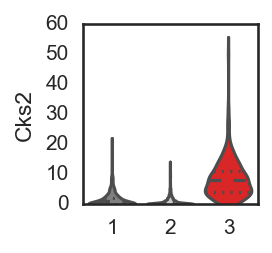

In [120]:
# with a violinplot
figure(figsize=(1.5,1.5))
violinplot([df.ix['CKS2', res == i] for i in set(res)], color=['0.5','0.8','r'], ec='k')
ylabel('Cks2') # Also Cdk1, Top2a, Pcna can be checked 
ylim(0)

In [121]:
cycling_cells = (res == 2).astype(float) # Cluster 3, in red, is chosen as the cycling cells cluster

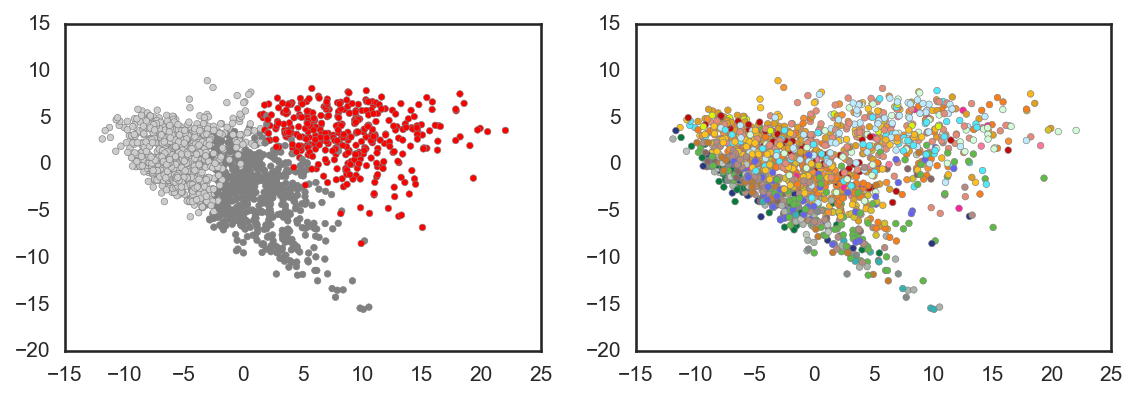

In [122]:
# Labels on PCA 2d projection
figure(figsize=(9,6))
subplot(221)
pca = PCA()
pca.fit(df_norm.T)
pcs = pca.transform(df_norm.T)
scatter(pcs[:,0],pcs[:,1], c=array(['0.5','0.8','r'])[res],s=10, edgecolor='0.5', lw = 0.3)

cell_types= array( [medium_dict[i] for i in cef.col_attr_values[1]] )
colors_cells = [map(lambda x: x/256., colors[i]) for i in cell_types]
subplot(222)
scatter(pcs[:,0],pcs[:,1], color=colors_cells, s=10, edgecolor='0.5', lw = 0.3 )

(-20.0, 20.0, -15.0, 15.0)

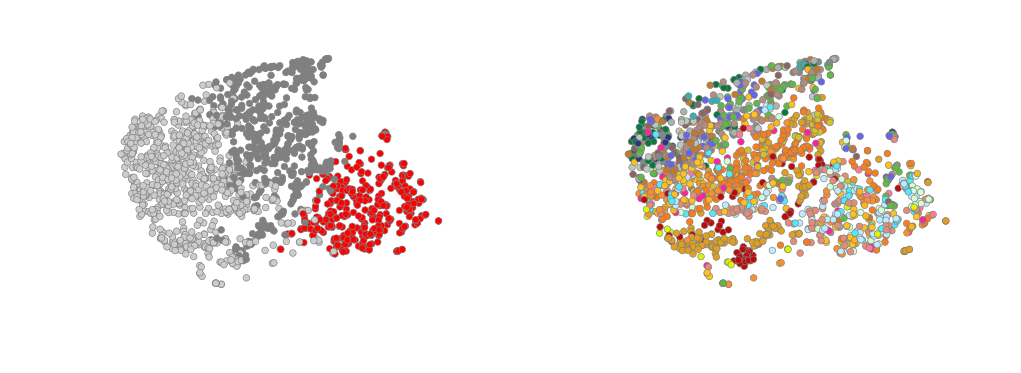

In [123]:
# Labels on TSNE 2d projection

subplot(221)
tsne = TSNE(2,perplexity=20.0, early_exaggeration=4.0, learning_rate=200, init='pca', random_state=15071990)
ts = tsne.fit_transform(df_norm.T)
scatter(ts[:,0],ts[:,1],c=array(['0.5','0.8','r'])[res],s=10, edgecolor='0.5', lw = 0.3)
axis('off')
subplot(222)
scatter(ts[:,0],ts[:,1], color=colors_cells, s=10, edgecolor='0.5', lw = 0.3 )
axis('off')

In [124]:
from sklearn.linear_model import Lasso, LassoCV, LassoLarsCV

In [125]:
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, StratifiedShuffleSplit

In [126]:
_, indexes_ = unique(celltypes, return_inverse=1)

## CrossValidation

In [128]:
from seaborn import reset_orig
reset_orig()
rcParams['figure.facecolor'] = 'w'

0.00252233988444


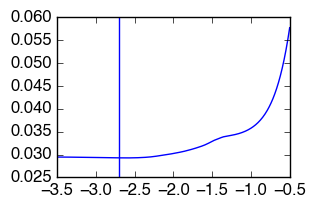

In [129]:
figure(figsize=(3,2))
lassocv = LassoCV(alphas=logspace(-3.5,-0.5,500),fit_intercept=False, positive=True,
                  cv=StratifiedShuffleSplit(indexes_, n_iter=30, test_size=0.15))
lassocv.fit( df_log.T, cycling_cells)
print lassocv.alpha_
chos = 0.002
axvline(log10(chos))
plot(log10(lassocv.alphas_), lassocv.mse_path_.mean(1))

In [130]:
lassocv = Lasso(alpha=chos, fit_intercept=True, positive=False)
lassocv.fit(df_log.T, cycling_cells)
y1 = lassocv.predict(df_log.T)

112


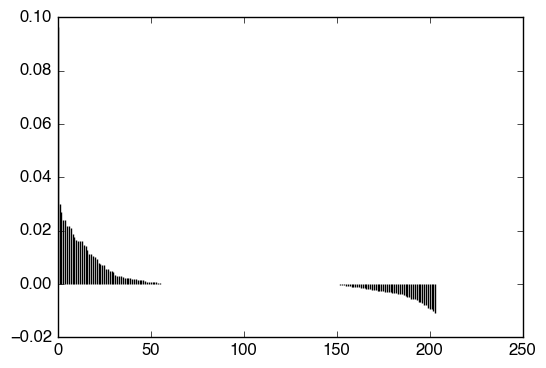

In [133]:
figure(figsize=(6,4))
print (abs(lassocv.coef_)>0).sum()
vlines(arange(lassocv.coef_.shape[0]), 0, sort(lassocv.coef_)[::-1] )

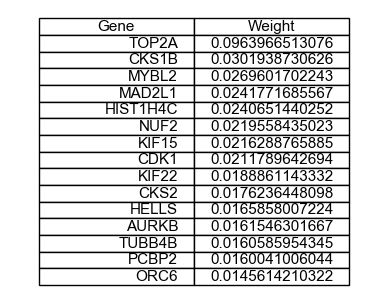

In [134]:
colLabels=("Gene", "Weight")
rows_list = zip( df_norm.index[ argsort( lassocv.coef_ )[::-1] ].tolist()[:15],\
                lassocv.coef_ [argsort( lassocv.coef_ )[::-1] ][:15])
nrows, ncols = len(rows_list)+1, len(colLabels)
hcell, wcell = 0.001, 2
hpad, wpad = 0, 0    
fig=plt.figure(figsize=(ncols*wcell+wpad, nrows*hcell+hpad))
ax = fig.add_subplot(111)
ax.axis('off')
the_table = ax.table(cellText=rows_list, colLabels=colLabels)

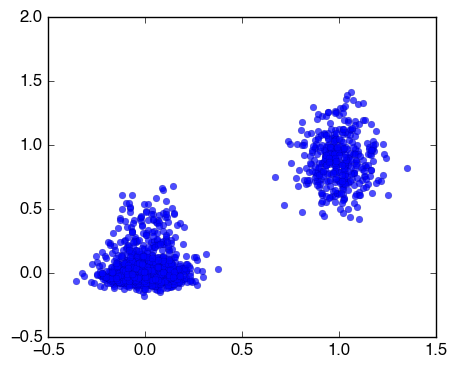

In [135]:
figure(figsize=(5,4))
scatter( cycling_cells+random.normal(0,0.1, size=y1.shape), y1, alpha=0.7, s=25, lw=0.1 )

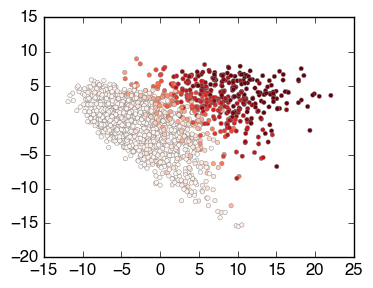

In [136]:
# Visualize the score on the PCA
figure(figsize=(4,3))
scatter(pcs[:,0],pcs[:,1], c=cm.Reds(y1),s=10, edgecolor='0.5', lw = 0.3)

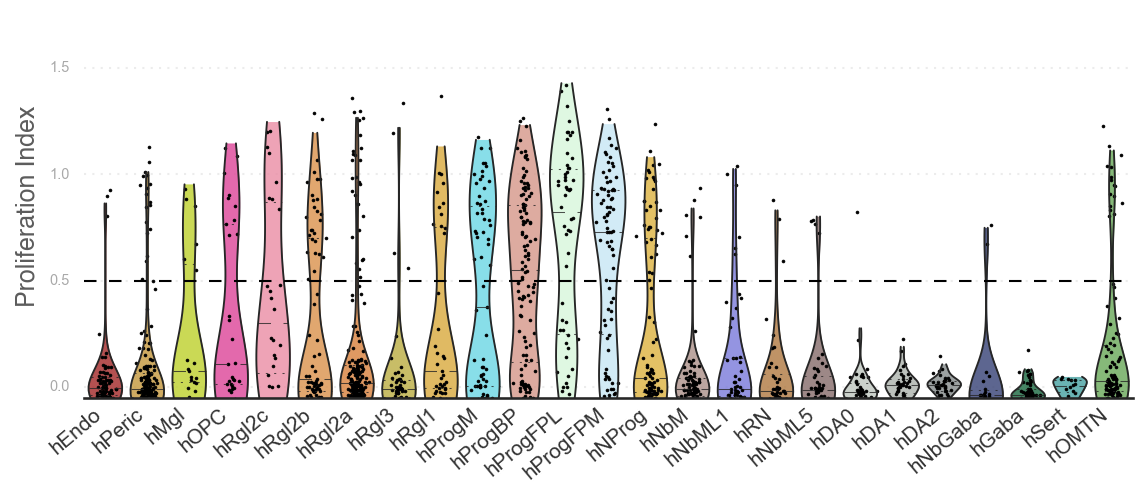

In [156]:
import seaborn as sns

fig = figure(figsize=(6.5*1.2,2.9*1.2))
sns.set(style="whitegrid", font="Arial Black")

d= array( [lassocv.predict(df_log.ix[:, celltypes == i].T) for i in wanted_order] )
d = array( [clip(i,-inf,percentile(i,98)) for i in d] )

sns.set(style ='white')

violinplot(d,inner='box',cut=0.2, linewidth=0.9,\
               names=wanted_order,\
               color=colors_reord, gridsize=55, inner_kws ={'linewidth':0.5},zorder=10, alpha=0.8)

xticks(rotation=40, horizontalalignment='right', verticalalignment='top',position=(0,0.02), fontsize='small', color=(0.2,0.2,0.2))
yticks(fontsize='xx-small', alpha=0.4)
ylabel('Proliferation Index', fontsize='medium', position=(-0.5,0.5), color=(0.2,0.2,0.2), alpha=0.8)

sns.despine(left=True);

grid( axis='y', color='gray', alpha =0.15, linestyle=':', zorder=-10000)
ylim(-0.05,1.75)

for n,i in enumerate( wanted_order):
    scatter( random.normal(n+1,0.1,df_log.ix[:, celltypes == i].T.shape[0]),\
            lassocv.predict(df_log.ix[:, celltypes == i].T), marker='.',color='k',s=8 )
axhline(y=0.5, color='k', linestyle='--', lw=1)
tight_layout()